In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline

In [2]:
train = pd.read_csv("/content/SentimentAnalysisTrain.csv")
test = pd.read_csv("SentimentAnalysisTest.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16363 entries, 0 to 16362
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16363 non-null  int64 
 1   text        16363 non-null  object
 2   label       16363 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 383.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2104 non-null   int64 
 1   text        2104 non-null   object
 2   label       2104 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 49.4+ KB


In [5]:
test.head()

,Unnamed: 0,text,label
0,1,Shanghai is also really exciting (precisely -...,1
1,2,"Recession hit Veronique Branquinho, she has to...",0
2,3,happy bday!,1
3,4,http://twitpic.com/4w75p - I like it!!,1
4,5,that`s great!! weee!! visitors!,1


In [6]:
train.drop("Unnamed: 0", axis=1, inplace = True)
test.drop("Unnamed: 0", axis=1, inplace = True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16363 entries, 0 to 16362
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16363 non-null  object
 1   label   16363 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 255.8+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2104 non-null   object
 1   label   2104 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.0+ KB


In [9]:
import torch 
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("There are ", torch.cuda.device_count(), 'GPU(s) available')
  print('Device Name: ', torch.cuda.get_device_name(0))
else:
    print('No GPU available')
    device = torch.device('cpu')

There are  1 GPU(s) available
Device Name:  Tesla T4


In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
X_train = train.text
y_train =  train.label
X_test = test.text
y_test =  test.label

In [12]:
def text_preprocessing(text):
  """
  - Lowercase the sentence
  - Change 't to not
  - Remove "@name"
  - remove punctuations except ?
  - Remove other special character
  - Remove stop words except (not and can)
  - Remove trainling white space
  """
  text = text.lower()

  # Change 't to 'not'
  text = re.sub(r"\'t", " not", text)
  # Remove @name
  text = re.sub(r'(@.*?)[\s]', ' ', text)
  # Isolate and remove punctuations except '?'
  text = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', text)
  text = re.sub(r'[^\w\s\?]', ' ', text)
  # Remove some special characters
  text = re.sub(r'([\;\:\|•«\n])', ' ', text)
  # Remove stopwords except 'not' and 'can'
  text = " ".join([word for word in text.split()
                if word not in stopwords.words('english')
                or word in ['not', 'can']])
  # Remove trailing whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  return text


In [13]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])


tf_idf = TfidfVectorizer(smooth_idf=False, use_idf=True)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)



CPU times: user 21.3 s, sys: 2.93 s, total: 24.2 s
Wall time: 25 s


In [14]:
X_train_preprocessed.shape

(16363,)

In [15]:
X_test_preprocessed.shape

(2104,)

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_AUC_CV(model):
  kf = StratifiedKFold(5, shuffle=True, random_state=1)

  auc = cross_val_score(model,
                        X_train_tfidf, y_train, scoring='roc_auc', cv=kf)
  
  return auc.mean()

In [17]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
  preds = probs[:, 1]
  fpr, tpr, threshold = roc_curve(y_true, preds)
  roc_auc = auc(fpr, tpr)
  print(f'AUC: {roc_auc:.4f}')
      
  # Get accuracy over the test set
  y_pred = np.where(preds >= 0.5, 1, 0)
  accuracy = accuracy_score(y_true, y_pred)
  print(f'Accuracy: {accuracy*100:.2f}%')
  
  # Plot ROC AUC
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


In [18]:
len(X_train_tfidf.todense())

16363

In [19]:
len(X_test_tfidf.todense())

2104

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB(alpha = 2)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_test_tfidf)

AUC: 0.9480
Accuracy: 86.93%


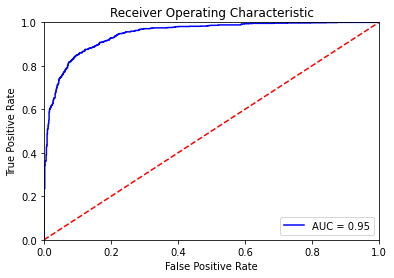

In [21]:
evaluate_roc(probs, y_test)

In [22]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 29.6 MB/s 
     |████████████████████████████████| 163 kB 66.0 MB/s 
     |████████████████████████████████| 7.6 MB 52.4 MB/s 


In [23]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def preprocessing_for_bert(data):
  input_ids = []
  attention_mask = []


  for text in data:
    encoded_text = tokenizer.encode_plus(
        text = text_preprocessing(text),
        add_special_tokens = True,
        max_length = MAX_LEN,
        pad_to_max_length = True,
        # return_tensor = 'pt',
        return_attention_mask = True
    )

    input_ids.append(encoded_text.get('input_ids'))
    attention_mask.append(encoded_text.get('attention_mask'))
  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)


  return input_ids, attention_mask
  

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
all_tweets = np.concatenate([train['text'], test['text']])

encoded_tweets = [tokenizer.encode(text, add_special_tokens=True) for text in all_tweets]

max_len = max([len(text) for text in encoded_tweets])
print("Max lenght: ", max_len)

Max lenght:  95


In [25]:
MAX_LEN = 95

token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print(token_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 17111, 2080, 6517, 3335, 2624, 5277, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [26]:
train_inputs, train_masks = preprocessing_for_bert(X_train)
test_inputs, test_masks = preprocessing_for_bert(X_test)

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [28]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits


CPU times: user 34.8 ms, sys: 0 ns, total: 34.8 ms
Wall time: 38.8 ms


In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
  """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
  """
  # Instantiate Bert Classifier
  bert_classifier = BertClassifier(freeze_bert=False)

  # Tell PyTorch to run the model on GPU
  bert_classifier.to(device)

  # Create the optimizer
  optimizer = AdamW(bert_classifier.parameters(),
                    lr=5e-5,    # Default learning rate
                    eps=1e-8    # Default epsilon value
                    )

  # Total number of training steps
  total_steps = len(train_dataloader) * epochs

  # Set up the learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0, # Default value
                                              num_training_steps=total_steps)
  return bert_classifier, optimizer, scheduler

In [30]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [31]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, test_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.587647   |     -      |     -     |   11.62  
   1    |   40    |   0.412991   |     -      |     -     |   8.93   
   1    |   60    |   0.311624   |     -      |     -     |   8.97   
   1    |   80    |   0.360649   |     -      |     -     |   9.06   
   1    |   100   |   0.295215   |     -      |     -     |   9.19   
   1    |   120   |   0.333067   |     -      |     -     |   9.23   
   1    |   140   |   0.272675   |     -      |     -     |   9.33   
   1    |   160   |   0.277659   |     -      |     -     |   9.37   
   1    |   180   |   0.253902   |     -      |     -     |   9.48   
   1    |   200   |   0.224112   |     -      |     -     |   9.55   
   1    |   220   |   0.265750   |     -      |     -     |   9.66   
   1    |   240   |   0.215937   |     -      |     -     |   9.74   


In [32]:
import xgboost as xgb
xgb_train  = xgb.DMatrix(X_train_tfidf, y_train)
xgb_test  = xgb.DMatrix(X_test_tfidf, y_test)

In [33]:
param = {'eta': 0.75,
         'max_depth': 50,
         'objective': 'binary:logistic',
         }


xgb_model = xgb.train(param,
                      xgb_train,
                      num_boost_round = 30)



In [34]:
y_preds = xgb_model.predict(xgb_test)

y_preds = np.where(np.array(y_preds) > 0.5, 1, 0)

print("Accuracy of the model :",(accuracy_score(y_test, y_preds)*100).round(2), '%')



Accuracy of the model : 86.6 %
